# Предсказание уровня удовлетворенности и возможного увольнения сотрудников HR-сервисом "Работа с заботой".

**Описание проекта:** HR-сервису "Работа с заботой" компания-заказчик предоставила данные, полученные с помощью анкеты обратной связи. С целью исключения финансовых потерь и оттока сотрудников сервису предстоит разработать и построить две модели: первая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика, вторая - предсказать то, что сотрудник уволится из компании.

Цель работы: предсказать возможное недовольство и увольнение сотрудника, а также, руководствуясь причинами недовольства компанией, сократить риски увольнения.

**Ход исследования:**

1 Задача: предсказание уровня удовлетворённости сотрудника.
* Подготовка данных: загрузка и изучение общей информации из представленного датасета;
* Предобработка данных: переименование столбцов, обработка пропущенных значений, корректировка типа данных, обработка дубликатов и других аномалий;
* Исследовательский анализ данных: изучение основных характеристик, их распределение;
* Подготовка данных, разработка и выбор классификационной модели-МО для предсказания уровня удовлетворённости сотрудника;
* Оформление выводов.

2 Задача: предсказание увольнения сотрудника из компании.
* Подготовка данных: загрузка и изучение общей информации из представленного датасета;
* Предобработка данных: переименование столбцов, обработка пропущенных значений, корректировка типа данных, обработка дубликатов и других аномалий;
* Исследовательский анализ данных: изучение основных характеристик, их распределение, составление портрета уволившегося сотрудника;
* Добавление нового входного признака;
* Подготовка данных, разработка и выбор классификационной модели-МО для предсказания увольнения.

**Общий вывод:** резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций.

## Задача. Предсказание уровня удовлетворённости сотрудника.

### Загрузка данных

Загрузим необходимые библиотеки

In [1]:
!pip install phik -q
!pip install scikit-learn==1.1.3 -q
!pip install matplotlib==3.5.2 -q

Импортируем библиотеки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats
from sklearn.metrics import   roc_auc_score, make_scorer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from phik.report import correlation_report, plot_correlation_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

Загрузим данные

In [3]:
try:
    X_y_train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    X_test = pd.read_csv('/datasets/test_features.csv')
    y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
except:
    X_y_train = pd.read_csv('F:\\Учеба яндекс\\projects\\8_work_with_pork\\train_job_satisfaction_rate.csv')
    X_test = pd.read_csv('F:\\Учеба яндекс\\projects\\8_work_with_pork\\test_features.csv')
    y_test = pd.read_csv('F:\\Учеба яндекс\\projects\\8_work_with_pork\\test_target_job_satisfaction_rate.csv')

**Изучим данные**

In [4]:
def first_look(df):
    df.info()
    return display(df.describe(),df.head(10))

Изучим тренировочнкую выборку

In [5]:
first_look(X_y_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


Изучим входные признаки тестовой выборки

In [6]:
first_look(X_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


Изучим целевой признак тестовой выборки

In [7]:
first_look(y_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


Проверим совпадение столбца id в датасете с входними признаками и в датасете с целевым признаком

In [8]:
id_list = X_test['id'].to_list()
y_test.query('id in @id_list').shape

(2000, 2)

Данные переданы верные, лишние id отсутствуют.

**Вывод:** из предварительного анализа заметно, что данные достаточно логичны, выбивающихся значений предварительно не обнаружено, пропусков немного. Необходима предобработка данных: поиск дубликатов в записанных данных, анализ возможности применения SimpleImputer. Так же можно заметить, что входные и целевой признаки в датасетах тестовой выборки разделены не соответственно друг другу.

### Предобработка данных

**Обработка пропусков**

Тренировочная выборка

In [9]:
X_y_train[X_y_train['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [10]:
X_y_train['dept'].value_counts()

sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64

Данные пропуски можно будет устранить в пайплайне.

In [11]:
X_y_train[X_y_train['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


In [12]:
X_y_train['level'].value_counts()

junior    1894
middle    1744
sinior     358
Name: level, dtype: int64

Так как наиболее частовстречающееся значение в столбце level - "junior", можно будет устранить их в пайплане. В дополнение стоит сказать, что во всех строках с пропущенным значением level стаж работы 1 год, что наиболее вероятно соответсвует уровню "junior".

Входные признаки тестовой выборки

In [13]:
X_test[X_test['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [14]:
X_test[X_test['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


**Проверим наличие строк-дубликатов**

Пhедварительно установим id в качестве индекса

In [15]:
X_y_train = X_y_train.set_index('id')

Тестовую выборку дополнительно отсортируем по id

In [16]:
X_test = X_test.sort_values(by = 'id').set_index('id')

In [17]:
y_test = y_test.sort_values(by = 'id').set_index('id')

Проверим наличие дубликатов

Тренировочная выборка

In [18]:
X_y_train.duplicated().sum()

245

In [20]:
X_y_train.drop_duplicates(inplace = True)

**Вывод:** при предобработке обнаружены пропуски, которые можно будет устранить с помощью SimpleImputer в пайплайне, заменив пропуски на наиболее часто встречающееся значение; название столбцов соответсвует стандарту, в качетсве индексов установлен столбец id, обнаружены строки, дублирующие значения, которые ухудшат обучение. Анализ строк с пропусками не показал наличие каки-либо зависимостей между ними, поэтому вероятнее всего, пропуски - следствие ошибок, возникших при записи/передаче/распаковке данных.

### Исследовательский анализ данных

Посмотрим распределения входных признаков, проанализируем на наличие экстраординарных значений.

In [20]:
def num_feature(data):
    display(data.describe())
    data.plot(kind = 'box', grid = True, figsize = (9,7))
    plt.title(f'Диаграмма размаха {data.name}', size = 15)
    plt.xlabel(data.name, size = 12)
    plt.show()
    data.hist(bins = 15, figsize = (9,7), edgecolor='black')
    plt.title(f'Гистограмма {data.name}', size = 15)
    plt.ylabel('Количество записей', size = 12)
    plt.xlabel(data.name, size = 12)
    plt.show()

In [21]:
def cat_feature(data):
    display(f'Количество уникальных значений в столбце равно {data.nunique()}')
    display(data.value_counts())
    data.value_counts().plot(kind = 'pie', autopct = '%1.1f%%', figsize = (9, 7))
    plt.title(f'Круговая диаграмма {data.name}', size = 15)
    plt.show()

#### Отдел

##### Тренировочные данные

'Количество уникальных значений в столбце равно 5'

sales         1374
technology     818
purchasing     586
marketing      531
hr             440
Name: dept, dtype: int64

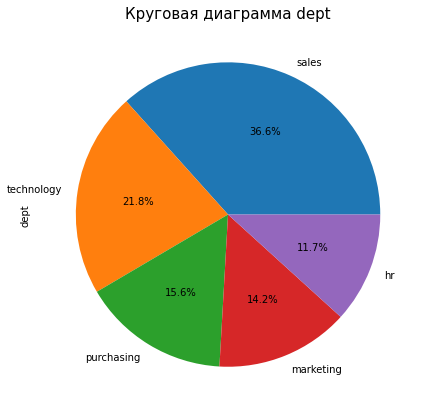

In [22]:
cat_feature(X_y_train['dept'])

Большинство работников работают в отделе продаж.

##### Тестовые данные

'Количество уникальных значений в столбце равно 6'

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

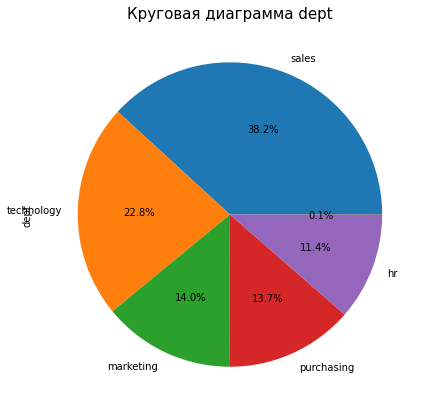

In [23]:
cat_feature(X_test['dept'])

Пропорции аналогичны. Встретился неявный пропуск, который необходимо удалить.

In [24]:
X_test['dept'].replace(' ', np.nan, inplace = True)

#### Уровень занимаемой должности

##### Тренировочные данные

'Количество уникальных значений в столбце равно 3'

junior    1699
middle    1695
sinior     357
Name: level, dtype: int64

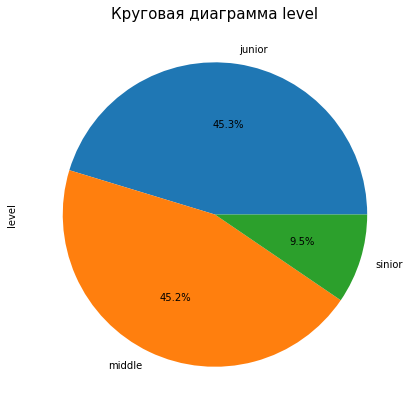

In [25]:
cat_feature(X_y_train['level'])

Работников уровня джуниор и мидл примерно поровну, синьоров в несколько раз меньше.

##### Тестовые данные

'Количество уникальных значений в столбце равно 3'

junior    974
middle    854
sinior    171
Name: level, dtype: int64

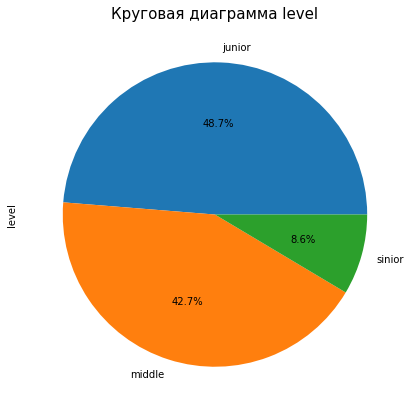

In [26]:
cat_feature(X_test['level'])

Пропорции аналогичны.

#### Уровень загруженности сотрудника

##### Тренировочные данные

'Количество уникальных значений в столбце равно 3'

medium    1908
low       1125
high       722
Name: workload, dtype: int64

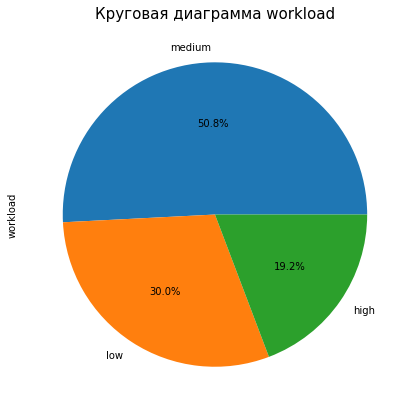

In [27]:
cat_feature(X_y_train['workload'])

Большинство работников нагружены средне, треть - малонагружены, пятая часть - высоконагруженные работники.

##### Тестовые данные

'Количество уникальных значений в столбце равно 4'

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

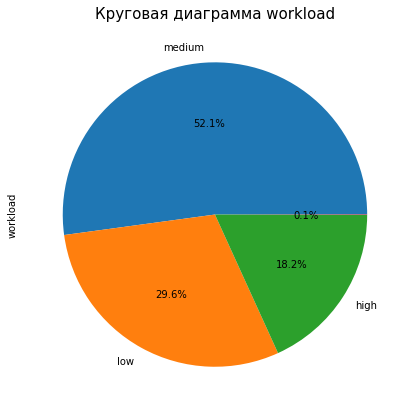

In [28]:
cat_feature(X_test['workload'])

Пропорции аналогичны.

#### Стаж работы в компании

##### Тренировочные данные

count    3755.000000
mean        3.817044
std         2.557142
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

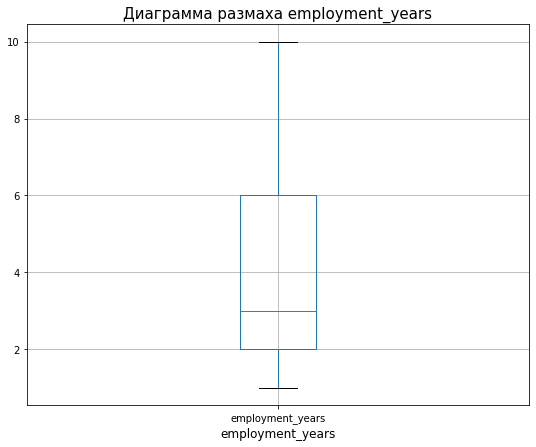

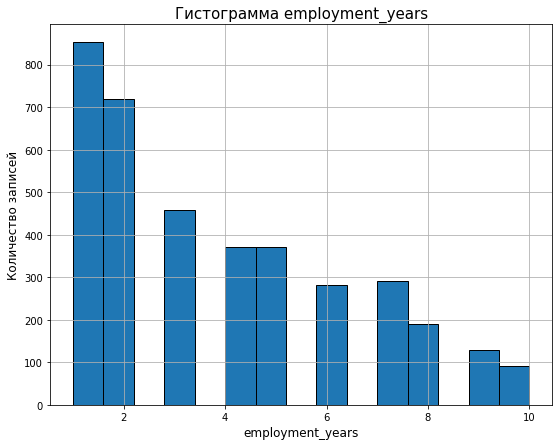

In [29]:
num_feature(X_y_train['employment_years'])

Более половины сотрудников компании работает менее 4-ех лет, что может говорить о том, что компания не так давно начала стремительно расширяться, больше всего сотрудников со стажем 1 год.

##### Тестовые данные

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

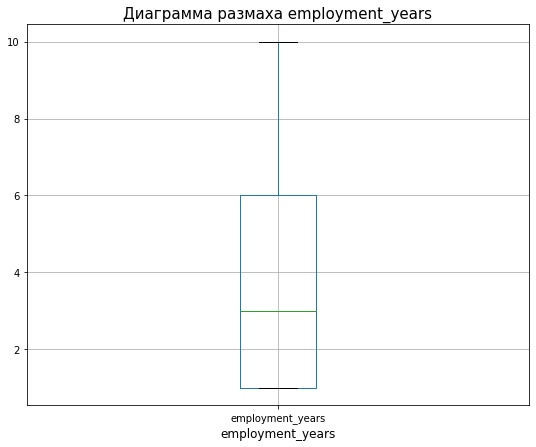

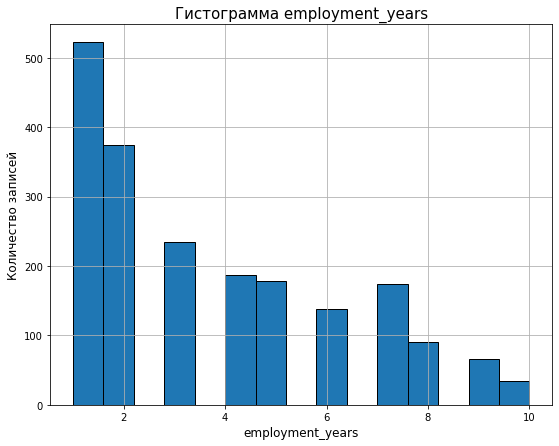

In [30]:
num_feature(X_test['employment_years'])

Выводы аналогичны.

#### Был ли повышен ли сотрудник за последний год

##### Тренировочные данные

'Количество уникальных значений в столбце равно 2'

no     3635
yes     120
Name: last_year_promo, dtype: int64

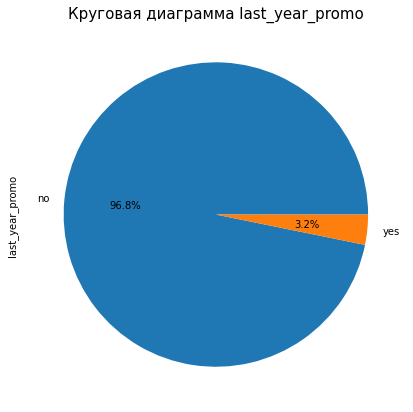

In [31]:
cat_feature(X_y_train['last_year_promo'])

Как видно из анализа, не так много людей получили повышение за последний год: 3%.

##### Тестовые данные

'Количество уникальных значений в столбце равно 2'

no     1937
yes      63
Name: last_year_promo, dtype: int64

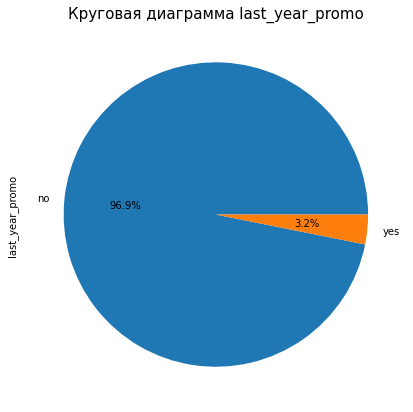

In [32]:
cat_feature(X_test['last_year_promo'])

Пропорции аналогичны.

#### Нарушал ли сотрудник трудовой договор за последний год

##### Тренировочные данные

'Количество уникальных значений в столбце равно 2'

no     3202
yes     553
Name: last_year_violations, dtype: int64

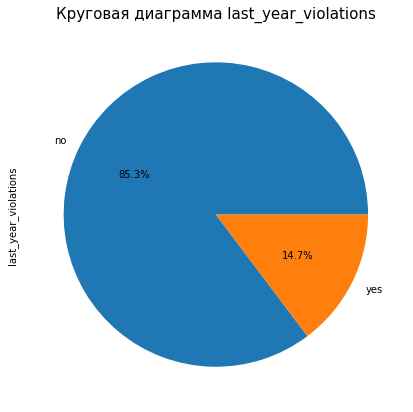

In [33]:
cat_feature(X_y_train['last_year_violations'])

Сотрудники компании достаточно прилежны: менее 15% нарушали трудовой договор за последний год.

##### Тестовые данные

'Количество уникальных значений в столбце равно 2'

no     1738
yes     262
Name: last_year_violations, dtype: int64

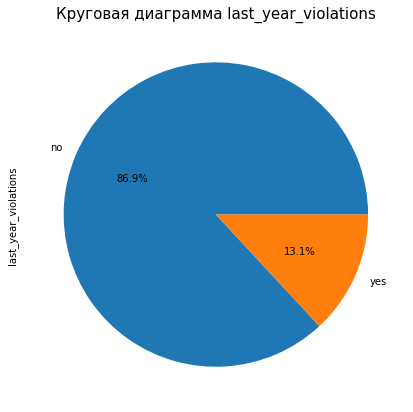

In [34]:
cat_feature(X_test['last_year_violations'])

Пропорции аналогичны.

#### Оценка сотрудника от руководителя

##### Тренировочные данные

count    3755.000000
mean        3.463648
std         1.026265
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

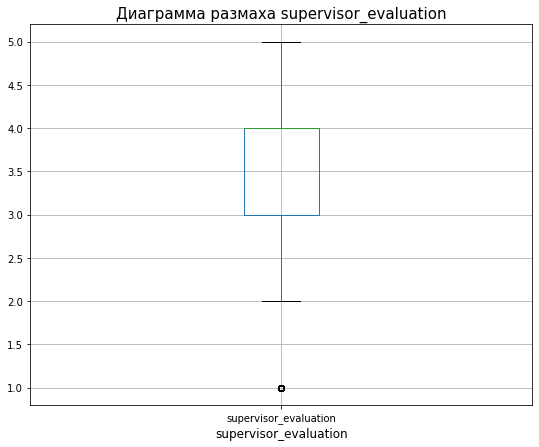

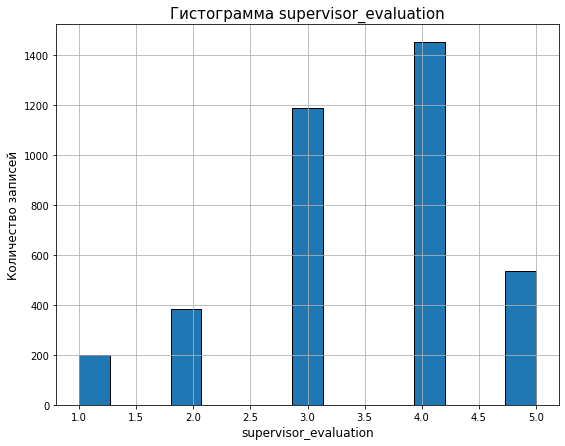

In [35]:
num_feature(X_y_train['supervisor_evaluation'])

Большая часть работников получили хорошие и отличные оценки, однако же есть часть работников, оцененных на наименьший балл.

##### Тестовые данные

count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

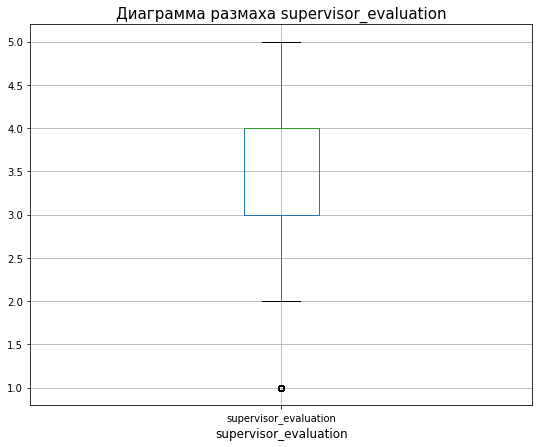

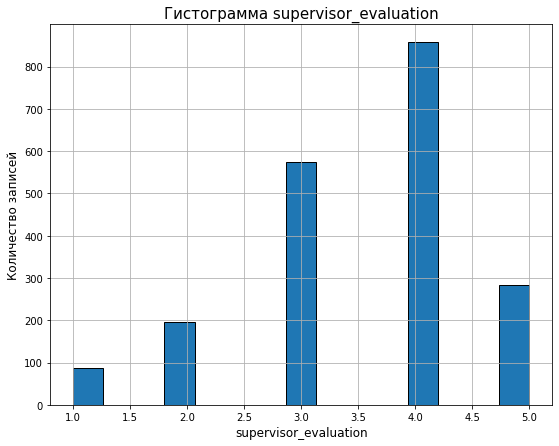

In [36]:
num_feature(X_test['supervisor_evaluation'])

Выводы аналогичны.

#### Зарплата

##### Тренировочные данные

count     3755.000000
mean     34457.416778
std      15050.643870
min      12000.000000
25%      22800.000000
50%      31200.000000
75%      44400.000000
max      98400.000000
Name: salary, dtype: float64

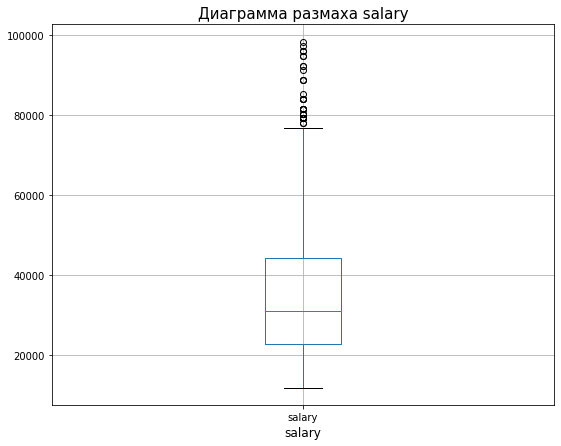

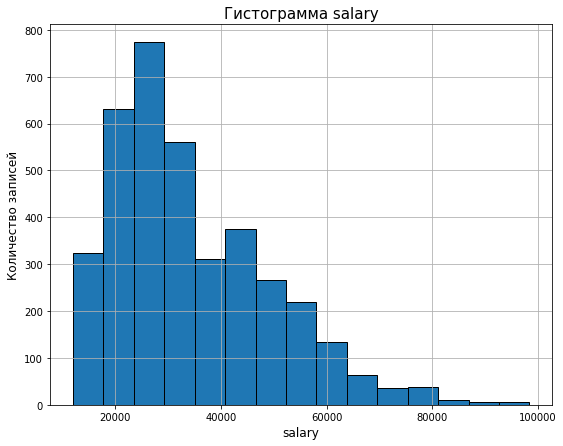

In [37]:
num_feature(X_y_train['salary'])

Распределеине зарплаты стремится к нормальному, однако наблюдается смещение влево, что говорит о том, что большая часть работников получает зарплату ниже среднего, что также можно увидеть из описания количественных данных: медиана = 34 тыс., мода = 30 тыс.

##### Тестовые данные

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

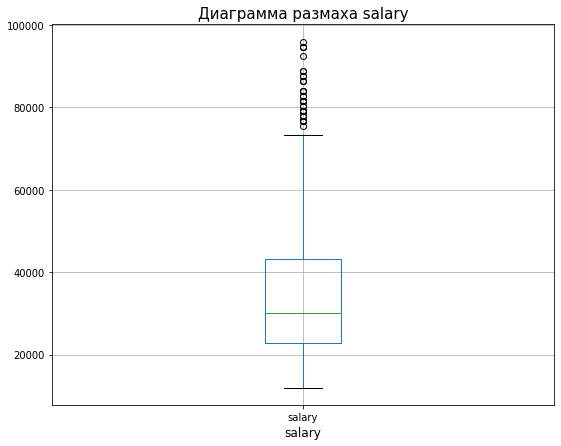

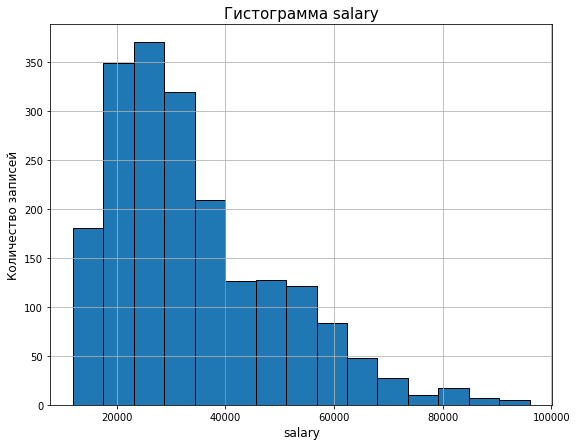

In [38]:
num_feature(X_test['salary'])

Выводы аналогичны.

#### Уровень удовлетворенности сотрудника работой в компании

##### Тренировочные данные

count    3755.000000
mean        0.532554
std         0.226393
min         0.030000
25%         0.350000
50%         0.550000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

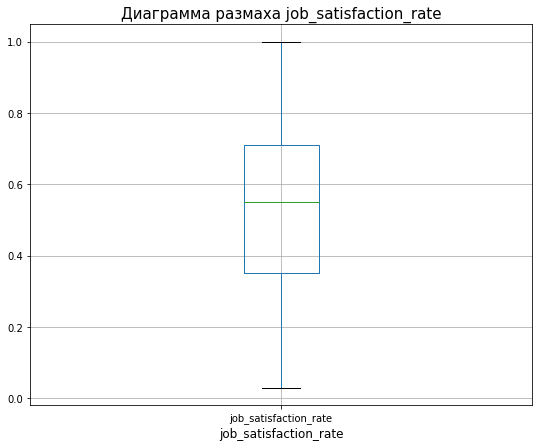

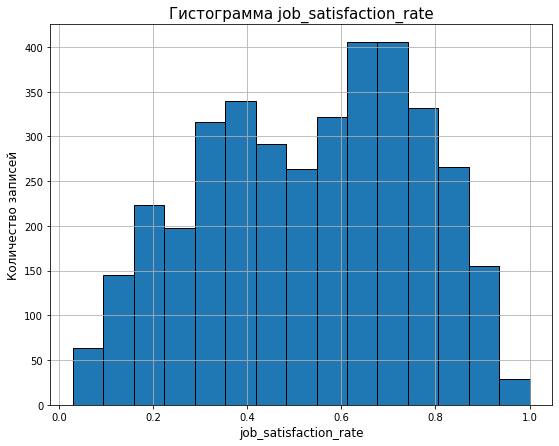

In [39]:
num_feature(X_y_train['job_satisfaction_rate'])

Распределение уровня удовлетворенности сотрудника работой в компании стремится к нормальному. Средний уровень удовлетворенности равен 0.53.

##### Тестовые данные

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

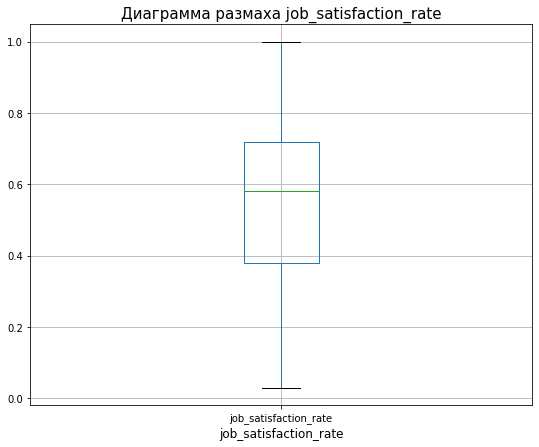

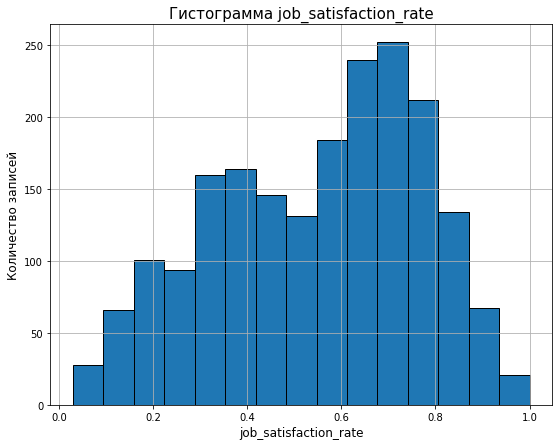

In [40]:
num_feature(y_test['job_satisfaction_rate'])

Выводы аналогичны.

#### Корреляционный анализ

В дополнение исследовательскому анализу можно провести корреляционный анализ, чтобы дополнительно проанализировать возможную корреляцию входных признаков и степень их влияния на целевой.

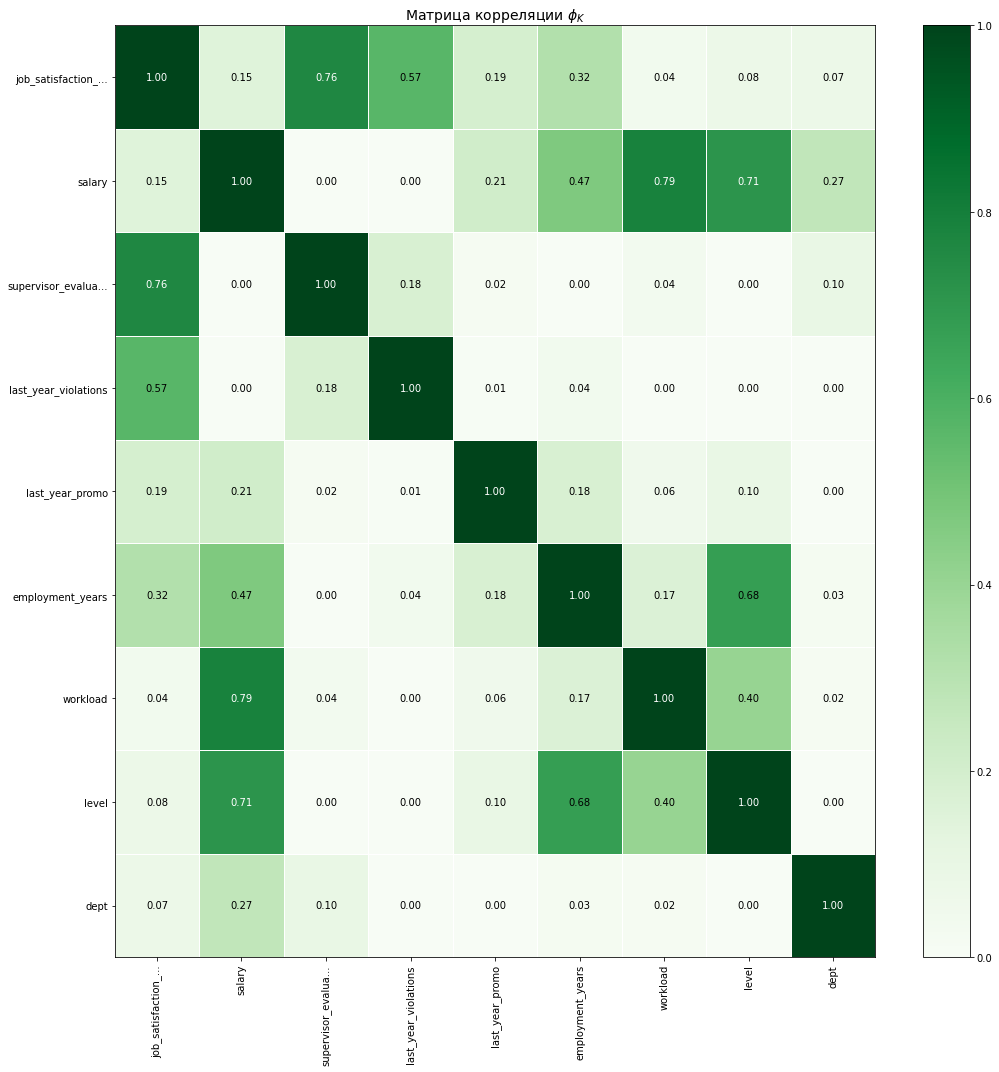

In [41]:
interval_cols = X_y_train.select_dtypes('number').columns.tolist()
phik_overview = X_y_train.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Матрица корреляции $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 15))
plt.tight_layout()

Корреляционный анализ позволил увидеть, что признаки относительно независимы, высокая корреляция наблюдается там, где ее логично увидеть: зарплата и нагрузка, зарплата и уровень должности, уровень должности и стаж работы. Корреляция оценки руководителя и удовлетворенность работой может быть объяснена тем, что когда работник получает удовольствие от своей работы, он лучше работает и соответственно это может быть отмечено его руководителем.

**Вывод:** проведен исследовательский анализ данных, в ходе которого установлено:
* Большинство работников работают в отделе продаж;
* Работников уровня джуниор и мидл примерно поровну, синьоров в несколько раз меньше;
* Большинство работников нагружены средне, треть - малонагружены, пятая часть - высоконагруженные работники;
* Более половины сотрудников компании работает менее 4-ех лет, что может говорить о том, что компания не так давно начала стремительно расширяться, больше всего сотрудников со стажем 1 год;
* Не так много людей получили повышение за последний год: 3%;
* Сотрудники компании достаточно прилежны: менее 15% нарушали трудовой договор за последний год;
* Большая часть работников получили хорошие и отличные оценки, однако же есть часть работников, оцененных на наименьший балл;
* Распределеине зарплаты стремится к нормальному, однако наблюдается смещение влево, что говорит о том, что большая часть работников получает зарплату ниже среднего;
* Распределение уровня удовлетворенности сотрудника работой в компании стремится к нормальному со средним 0.53.

В ходе исследовательского анализа не установлена особая прямая или полиномиальная связь между входними и целевым признаками.

### Разработка и применение ML-модели для прогнозирования уровня удовлетворенности сотрудника работой в компании

Разделим входные и целевой признаки

In [42]:
RANDOM_STATE = 42

X_train = X_y_train.drop(['job_satisfaction_rate'], axis = 1)
y_train = X_y_train['job_satisfaction_rate']

Отберем столбцы для различного преобразования

In [43]:
ohe_cols = (
    X_y_train.columns.
    drop(interval_cols)
    .drop(['level', 'workload'])
    .tolist()
)
ord_cols = ['level', 'workload']
num_cols = (
    X_y_train
    .drop(['job_satisfaction_rate'],axis =1)
    .select_dtypes('number')
    .columns.tolist())

Соберем пайплайн для кодировки порядковых категорий

In [44]:
ord_pipe = Pipeline(
[('impute_before_ord', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),
 ('ord', OrdinalEncoder(categories = [
     ['junior','middle','sinior'],
     ['low','medium','high']], handle_unknown='use_encoded_value', unknown_value = np.nan)),
 ('impute_after_ord', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent'))
 
])

Соберем пайплайн для подготовки данных перед обучением

In [45]:
ohe_pipe = Pipeline([
    ('impute_befor_ohe', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),
    ('ohe', OneHotEncoder(drop = 'first', sparse = False, handle_unknown = 'ignore')),
])

In [46]:
preprocessor = ColumnTransformer(
[
    ('ord_pipe', ord_pipe, ord_cols),
    ('ohe_pipe', ohe_pipe, ohe_cols),#
    ('num', StandardScaler(),num_cols)
], remainder = 'passthrough')

Соберем финальный пайплайн

In [47]:
final_pipe = Pipeline([
    ('data_preprocessor', preprocessor),
    ('models', DecisionTreeRegressor(random_state = RANDOM_STATE))
])

Настроим сетку параметров для нахождения лучшей модели

In [48]:
param_grid = [
    {'models': [LinearRegression()],
     'data_preprocessor__num': [MinMaxScaler(),StandardScaler(), 'passthrough']},
    {'models': [Lasso()],
     'models__alpha': np.logspace(-2,3,6),
     'data_preprocessor__num': [MinMaxScaler(),StandardScaler(), 'passthrough']},
    {'models': [DecisionTreeRegressor(random_state = RANDOM_STATE)],
     'models__max_depth': range(16,20),
     'models__min_samples_split': range(5,8),
     'models__min_samples_leaf': range(1,5),
     'models__max_features': range(6,8),
     'data_preprocessor__num': [MinMaxScaler(),StandardScaler(), 'passthrough']
    }
]

Разработаем необходимую метрику определения лучшей модели

In [49]:
def SMAPE_score(y_true,y_preds):
    summ = (np.abs(np.array(y_true)) + np.abs(np.array(y_preds)))/2
    diff = np.abs(np.array(y_true)-np.array(y_preds))
    return 100*np.sum(diff/summ)/len(y_true)
SMAPE = make_scorer(SMAPE_score, greater_is_better = False)

Запустим поиск лучшей модели

In [50]:
grid_search = RandomizedSearchCV(
final_pipe,
param_grid,
random_state = RANDOM_STATE,
cv = 5,
n_iter = 50,
scoring = SMAPE)

In [51]:
grid_search.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('data_preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ord_pipe',
                                                                               Pipeline(steps=[('impute_before_ord',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(categories=[['junior',
                                                                                                                            'middle',
                                                                                                                            'sinior'],
                                                                                                                           ['low',
                                                                                                                            'medium',
                                                                                                                            'high']],
                                                                                                               handle_unknown='use_encoded_value',
                                                                                                               unknown_va...
                                        {'data_preprocessor__num': [MinMaxScaler(),
                                                                    StandardScaler(),
                                                                    'passthrough'],
                                         'models': [DecisionTreeRegressor(max_depth=18,
                                                                          max_features=7,
                                                                          min_samples_split=6,
                                                                          random_state=42)],
                                         'models__max_depth': range(16, 20),
                                         'models__max_features': range(6, 8),
                                         'models__min_samples_leaf': range(1, 5),
                                         'models__min_samples_split': range(5, 8)}],
                   random_state=42,
                   scoring=make_scorer(SMAPE_score, greater_is_better=False))

In [52]:
print(f'Метрика SMAPE для лучшей модели:\n{-grid_search.best_score_:.3f}')
print('\nЛучшая модель и её параметры:\n\n', grid_search.best_estimator_)

Метрика SMAPE для лучшей модели:
15.088

Лучшая модель и её параметры:

 Pipeline(steps=[('data_preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord_pipe',
                                                  Pipeline(steps=[('impute_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'sinior'],
                                                                                              ['low',
                                                                              

In [53]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(grid_search.cv_results_)
result['mean_test_score'] = -result['mean_test_score']
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head()

,rank_test_score,param_models,mean_test_score,params
32,1,"DecisionTreeRegressor(max_depth=18, max_features=7, min_samples_split=6,\n random_state=42)",15.088180,"{'models__min_samples_split': 6, 'models__min_samples_leaf': 1, 'models__max_features': 7, 'models__max_depth': 18, 'models': DecisionTreeRegressor(max_depth=18, max_features=7, min_samples_split=6, random_state=42), 'data_preprocessor__num': MinMaxScaler()}"
28,2,"DecisionTreeRegressor(max_depth=18, max_features=7, min_samples_split=6,\n random_state=42)",15.119438,"{'models__min_samples_split': 6, 'models__min_samples_leaf': 1, 'models__max_features': 7, 'models__max_depth': 18, 'models': DecisionTreeRegressor(max_depth=18, max_features=7, min_samples_split=6, random_state=42), 'data_preprocessor__num': 'passthrough'}"
2,3,"DecisionTreeRegressor(max_depth=18, max_features=7, min_samples_split=6,\n random_state=42)",15.316033,"{'models__min_samples_split': 5, 'models__min_samples_leaf': 1, 'models__max_features': 7, 'models__max_depth': 17, 'models': DecisionTreeRegressor(max_depth=18, max_features=7, min_samples_split=6, random_state=42), 'data_preprocessor__num': MinMaxScaler()}"
46,4,"DecisionTreeRegressor(max_depth=18, max_features=7, min_samples_split=6,\n random_state=42)",15.337820,"{'models__min_samples_split': 6, 'models__min_samples_leaf': 1, 'models__max_features': 7, 'models__max_depth': 16, 'models': DecisionTreeRegressor(max_depth=18, max_features=7, min_samples_split=6, random_state=42), 'data_preprocessor__num': 'passthrough'}"
30,5,"DecisionTreeRegressor(max_depth=18, max_features=7, min_samples_split=6,\n random_state=42)",15.389740,"{'models__min_samples_split': 5, 'models__min_samples_leaf': 2, 'models__max_features': 7, 'models__max_depth': 19, 'models': DecisionTreeRegressor(max_depth=18, max_features=7, min_samples_split=6, random_state=42), 'data_preprocessor__num': MinMaxScaler()}"


Подбор гиперпараметров к ML-моделям показал, что наилучшей моделью является дерево решений.

In [54]:
f'Метрика SMAPE для модели дерева решений: \
{SMAPE_score(y_test["job_satisfaction_rate"], grid_search.best_estimator_.predict(X_test)):.2f}'

'Метрика SMAPE для модели дерева решений: 13.66'

Данная модель показывает достаточный уровень точности на тестовой выборке.

**Вывод:** проведенный выбор лучшей модели и подбор гиперпараметров показал, что наиболее точной является модель регрессии дерева решений с max_depth=18, max_features=7, min_samples_split=6. Также стоит отметить, что среди наилучших моделей преобладают более сложные модели, в то время как обнуляющая входные признаки лассо-регрессия (с малым коэффициентом регуляризации) имеет худший показатель метрики из анализируемых метрик, что говорит о высокой степени сложности зависимостей между входыми признаками и целевым.

### Выводы к 1 задаче

Основываясь на данных компании заказчика проведены ***предобработка данных***, включающая в себя проверку наличия дубликатов, пропусков, установку id в качетсве индекса; ***исследовательский анализ данных***, в ходе которого не установлена особая прямая или полиномиальная связь между входними и целевым признаками; ***разработка и применение ML-модели для прогнозирования уровня удовлетворенности сотрудника работой в компании***, с помощью которой была найдена лучшая модель, удовлетворяющая требованию по установленному порогу SMAPE<=15: модель регрессии дерева решений с  max_depth=18, max_features=7, min_samples_split=6. Расчитанное SMAPE на тестовой выборке равно 13.66.

## Задача. Предсказание увольнения сотрудника из компании

### Загрузка данных

Загрузим данные

In [55]:
try:
    X_y_train = pd.read_csv('/datasets/train_quit.csv')
    X_y_test = X_test.join(y_test, how = 'inner')
    y_test = pd.read_csv('/datasets/test_target_quit.csv')
except:
    X_y_train = pd.read_csv('F:\\Учеба яндекс\\projects\\8_work_with_pork\\train_quit.csv')
    X_y_test = X_test.join(y_test, how = 'inner')
    y_test = pd.read_csv('F:\\Учеба яндекс\\projects\\8_work_with_pork\\test_target_quit.csv')

**Изучим данные**

Изучим тренировочнкую выборку

In [56]:
first_look(X_y_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes
6,417070,technology,middle,medium,8,no,no,2,44400,no
7,165489,sales,middle,low,4,no,no,5,19200,no
8,996399,marketing,middle,low,7,no,no,4,25200,no
9,613206,technology,middle,medium,2,no,no,3,45600,yes


Изучим целевой признак тестовой выборки

In [57]:
first_look(y_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,id
count,2000.000000
mean,552765.213500
std,253851.326129
min,100298.000000
25%,339052.000000
50%,550793.000000
75%,765763.750000
max,999029.000000


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no


Проверим совпадение столбца id в датасете с входними признаками и в датасете с целевым признаком

Данные переданы верные, лишние id отсутствуют.

**Вывод:** из предварительного анализа заметно, что данные достаточно логичны, выбивающихся значений предварительно не обнаружено, пропусков нет. Необходима предобработка данных: поиск дубликатов в записанных данных.

### Предобработка данных

**Проверим наличие экстразначений в столбце quit**

In [58]:
X_y_train['quit'].value_counts()

no     2872
yes    1128
Name: quit, dtype: int64

In [59]:
y_test['quit'].value_counts()

no     1436
yes     564
Name: quit, dtype: int64

**Проверим наличие строк-дубликатов**

Установим id в качестве индекса

In [60]:
X_y_train = X_y_train.set_index('id')

In [61]:
X_y_train.duplicated().sum()

1413

Тестовую выборку дополнительно отсортируем по id

In [62]:
y_test = y_test.sort_values(by = 'id').set_index('id')

**Вывод:** при предобработке пропуски не обнаружены; название столбцов соответсвует стандарту, строки-дубликаты не обнаружены. Также в качетсве индексов установлен столбец id.

### Исследовательский анализ данных

Напишем функции для исследовательского анализа и составления портрета уволившегося сотрудника:

In [63]:
def num_feature_quit(name):
    print(f'Основные описательные статистики {X_y_train[name].name} уволившихся сотрудников')
    display(X_y_train.query('quit == "yes"')[name].describe())
    print(f'Основные описательные статистики {X_y_train[name].name} оставшихся сотрудников')
    display(X_y_train.query('quit == "no"')[name].describe())
    sns.boxplot(data = X_y_train, y = name, x = 'quit', order = ['yes','no'])
    plt.title(f'Диаграмма размаха {X_y_train[name].name}', size = 15)
    plt.xlabel(X_y_train[name].name, size = 12)
    plt.show()
    X_y_train.query('quit == "yes"')[name].hist(bins = 15,
                                                figsize = (9,7),
                                                edgecolor='black',
                                                label = 'уволились',
                                                alpha = 0.5)
    X_y_train.query('quit == "no"')[name].hist(bins = 15,
                                               figsize = (9,7),
                                               edgecolor='black',
                                               label = 'остались',
                                               alpha = 0.5)
    plt.title(f'Гистограмма {X_y_train[name].name}', size = 15)
    plt.ylabel('Количество записей', size = 12)
    plt.xlabel(X_y_train[name].name, size = 12)
    plt.legend()
    plt.show()

In [64]:
def cat_feature_quit(name):
    display(f'Количество уникальных значений в столбце равно {X_y_train[name].nunique()}')
    display(f'Доли уволившихся и оставшихся сотрудников для {name}:')    

    display(round(X_y_train.groupby([name])['quit'].value_counts(normalize=True),3))

#построение диаграмм
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10)) 

    
    values = X_y_train.query('quit == "yes"')[name].value_counts()
    ax1.pie(x = values,
            labels = X_y_train.query('quit == "yes"')[name].value_counts().index,
            autopct = '%1.1f%%')
    ax1.set_title(f'{X_y_train[name].name} для уволившихся сотрудников')
    values = X_y_train.query('quit == "no"')[name].value_counts()
    ax2.pie(x = values,
            labels = X_y_train.query('quit == "no"')[name].value_counts().index,
            autopct = '%1.1f%%') #plot second pie
    ax2.set_title(f'{X_y_train[name].name} для оставшихся сотрудников')

    plt.show()

#### Отдел

'Количество уникальных значений в столбце равно 5'

'Доли уволившихся и оставшихся сотрудников для dept:'

dept        quit
hr          no      0.750
            yes     0.250
marketing   no      0.720
            yes     0.280
purchasing  no      0.718
            yes     0.282
sales       no      0.717
            yes     0.283
technology  no      0.703
            yes     0.297
Name: quit, dtype: float64

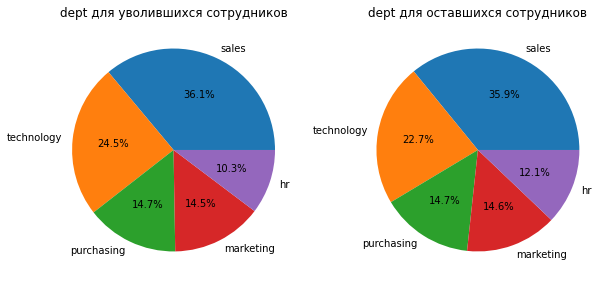

In [65]:
cat_feature_quit('dept')

Анализ не показал заметного различия доли уволившихся сотрудников в зависимости от отдела. Наибольшая доля увольнений в отделе закупок - 28%, наименьшая - в HR - 24%.

Невозможно однозначно сказать о наличии влияния отдела на увольнение сотрудника. Велика вероятность, что влияние минимально.

#### Уровень занимаемой должности

'Количество уникальных значений в столбце равно 3'

'Доли уволившихся и оставшихся сотрудников для level:'

level   quit
junior  yes     0.515
        no      0.485
middle  no      0.936
        yes     0.064
sinior  no      0.952
        yes     0.048
Name: quit, dtype: float64

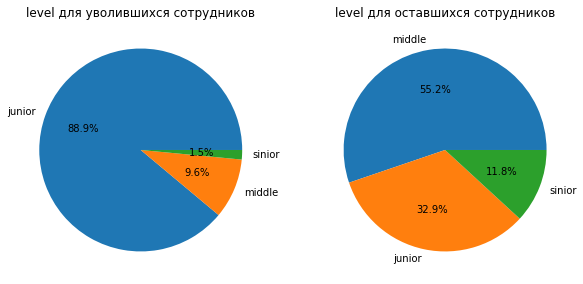

In [66]:
cat_feature_quit('level')

Из проведенного анализа видно, что доля увольняющихся джуниоров намного больше, нежели продолжающих работать. Почти 90% увольняющихся сотрудников - джуниоры, в то время как увольняющихся мидлов и синьоров менее 10%.

#### Уровень загруженности сотрудника

'Количество уникальных значений в столбце равно 3'

'Доли уволившихся и оставшихся сотрудников для workload:'

workload  quit
high      no      0.82
          yes     0.18
low       no      0.57
          yes     0.43
medium    no      0.77
          yes     0.23
Name: quit, dtype: float64

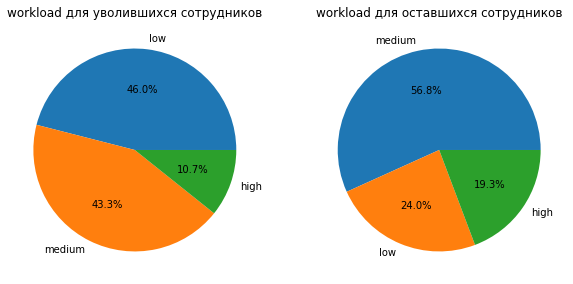

In [67]:
cat_feature_quit('workload')

Нельзя говорить о высокой степени влияния нагрузки на персонал на увольнение, однако в основном увольняются сотрудники с низкой и средней загруженностью.

#### Стаж работы в компании

Основные описательные статистики employment_years уволившихся сотрудников


count    1128.000000
mean        1.844858
std         1.274920
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: employment_years, dtype: float64

Основные описательные статистики employment_years оставшихся сотрудников


count    2872.000000
mean        4.430710
std         2.544635
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

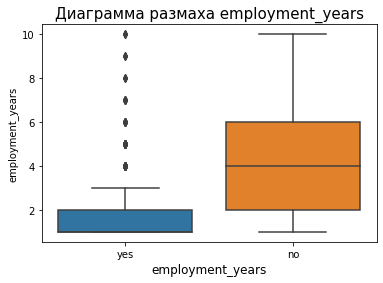

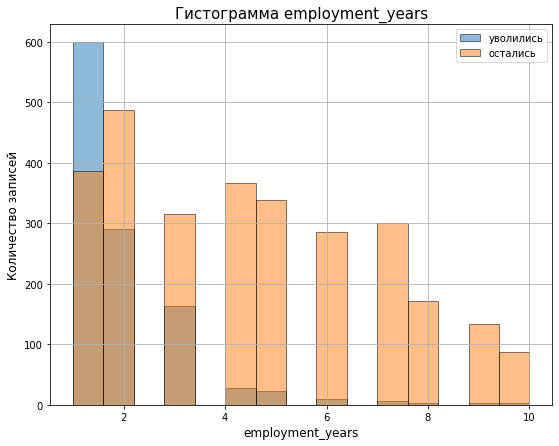

In [68]:
num_feature_quit('employment_years')

Анализ показывает, что более половины уволившихся сотрудников проработали в компании один год. Таким образом, можно сделать вывод: у сотрудников со стажем 1-2 года наиболее высока вероятность увольнения.

#### Был ли повышен ли сотрудник за последний год

'Количество уникальных значений в столбце равно 2'

'Доли уволившихся и оставшихся сотрудников для last_year_promo:'

last_year_promo  quit
no               no      0.710
                 yes     0.290
yes              no      0.991
                 yes     0.009
Name: quit, dtype: float64

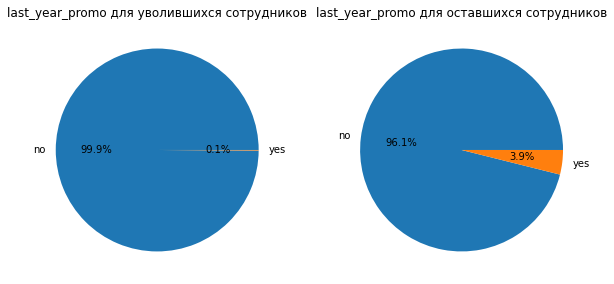

In [69]:
cat_feature_quit('last_year_promo')

Анализ показывает, что абсолютное большинство уволившихся сотрудников не претерпевали повышеине в последний год.

#### Нарушал ли сотрудник трудовой договор за последний год

'Количество уникальных значений в столбце равно 2'

'Доли уволившихся и оставшихся сотрудников для last_year_violations:'

last_year_violations  quit
no                    no      0.740
                      yes     0.260
yes                   no      0.582
                      yes     0.418
Name: quit, dtype: float64

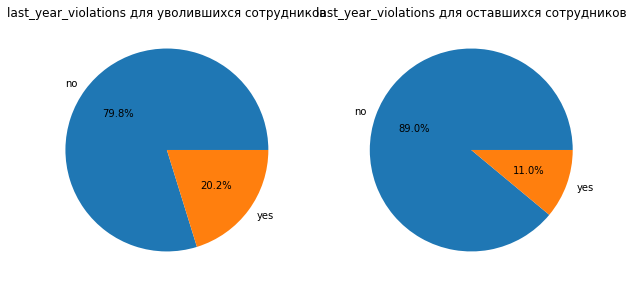

In [70]:
cat_feature_quit('last_year_violations')

Невозможно однозначно сказать о наличии влияния нарушений трудового договора на увольнение. Велика вероятность, что влияние минимально.

#### Оценка сотрудника от руководителя

Основные описательные статистики supervisor_evaluation уволившихся сотрудников


count    1128.000000
mean        3.046099
std         0.973291
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

Основные описательные статистики supervisor_evaluation оставшихся сотрудников


count    2872.000000
mean        3.643106
std         0.965295
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

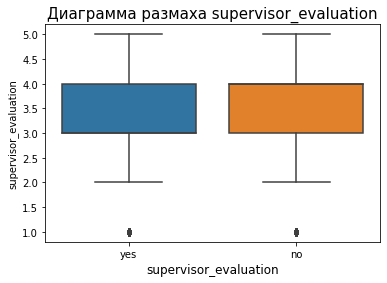

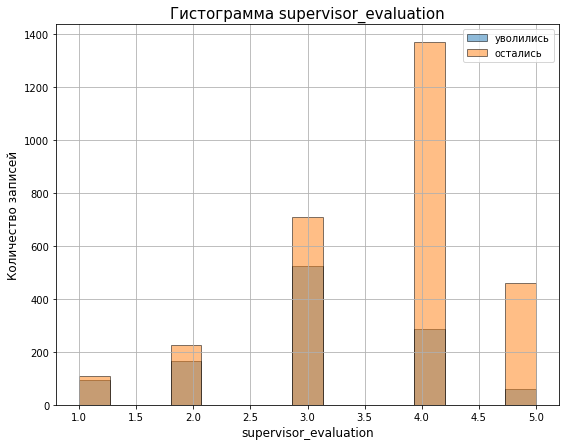

In [71]:
num_feature_quit('supervisor_evaluation')

Анализ показывает, что средняя оценка уволившихся сотрудников меньше, нежели оставшихся.

#### Зарплата

Основные описательные статистики salary уволившихся сотрудников


count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64

Основные описательные статистики salary оставшихся сотрудников


count     2872.000000
mean     37702.228412
std      15218.977339
min      12000.000000
25%      25200.000000
50%      34800.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64

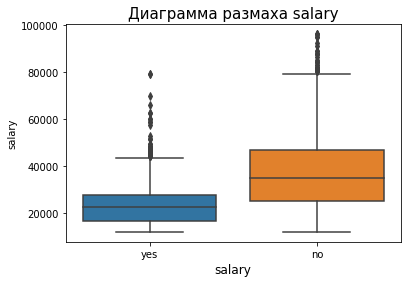

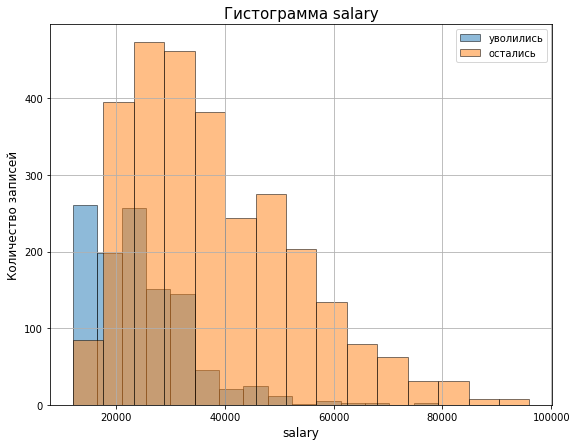

In [72]:
num_feature_quit('salary')

Из анализа видно, что средняя зарплата уволившихся сотрудников в 1.5 раза меньше, нежели оставшихся. Велика вероятность, что признаки зарплата, стаж работы и уровень занимаемой должности коррелируют между собой, поэтому логично увидеть более низкую зарплату у уволившихся сотрудников.

#### Уровень удовлетворенности сотрудника работой в компании

Анализ влияния уровня удовлетворенности сотрудника работой в компании на уход из нее проведем на тестовой выборке

Основные описательные статистики уровень удовлетворенности работой уволившихся сотрудников


count    564.000000
mean       0.387713
std        0.185784
min        0.040000
25%        0.240000
50%        0.370000
75%        0.492500
max        0.970000
Name: job_satisfaction_rate, dtype: float64

Основные описательные статистики уровень удовлетворенности оставшихся сотрудников


count    1436.000000
mean        0.612040
std         0.199367
min         0.030000
25%         0.500000
50%         0.660000
75%         0.760000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

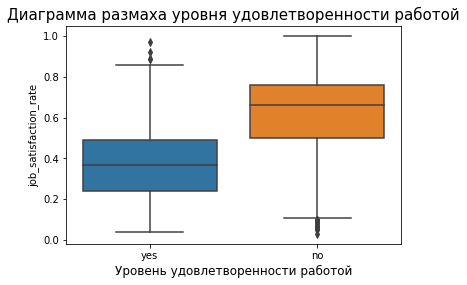

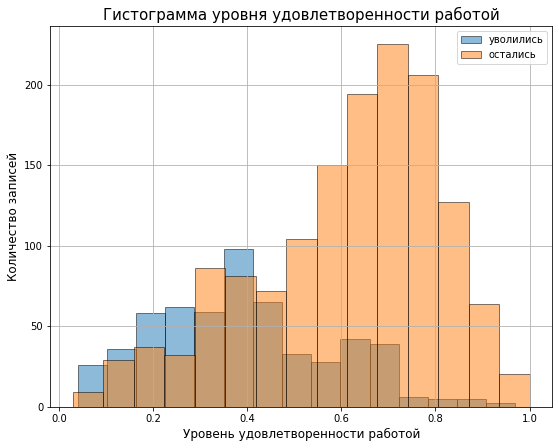

In [73]:
X_y_test = X_y_test.join(y_test, how = 'inner')
print(f'Основные описательные статистики уровень удовлетворенности работой уволившихся сотрудников')
display(X_y_test.query('quit == "yes"')['job_satisfaction_rate'].describe())
print(f'Основные описательные статистики уровень удовлетворенности оставшихся сотрудников')
display(X_y_test.query('quit == "no"')['job_satisfaction_rate'].describe())
sns.boxplot(data = X_y_test, y = 'job_satisfaction_rate', x = 'quit', order = ['yes','no'])
plt.title(f'Диаграмма размаха уровня удовлетворенности работой', size = 15)
plt.xlabel('Уровень удовлетворенности работой', size = 12)
plt.show()
X_y_test.query('quit == "yes"')['job_satisfaction_rate'].hist(bins = 15,
                                                              figsize = (9,7),
                                                              edgecolor='black',
                                                              label = 'уволились',
                                                              alpha = 0.5)
X_y_test.query('quit == "no"')['job_satisfaction_rate'].hist(bins = 15,
                                                             figsize = (9,7),
                                                             edgecolor='black',
                                                             label = 'остались',
                                                             alpha = 0.5)
plt.title(f'Гистограмма уровня удовлетворенности работой', size = 15)
plt.ylabel('Количество записей', size = 12)
plt.xlabel('Уровень удовлетворенности работой', size = 12)
plt.legend()
plt.show()

Анализ показывает, что уровень удовлетворенности работой вероятнее всего влияет на уход сотрудника: так сотрудники с низким уровнем удовлетворенности (средний уровень удовлетворенности уволившихся равен 0.39) более склонны к увольнению, нежели с высоким (средний уровень удовлетворенности оставшихся равен 0.61).

Исходя из проведенного анализа требуется добавление признака job_satisfaction_rate к тестовым данным

In [74]:
X_y_train['job_satisfaction_rate'] = grid_search.best_estimator_.predict(X_y_train.drop(['quit'], axis = 1))

In [75]:
X_test['job_satisfaction_rate'] = grid_search.best_estimator_.predict(X_test)

**Вывод:** проведен исследовательский анализ данных, в ходе которого установлено:

* Скорее всего влияние отдела на увольнение невелико;
* Почти 90% увольняющихся сотрудников - джуниоры;
* В основном увольняются сотрудники с низкой и средней загруженностью;
* Более половины уволившихся сотрудников проработали в компании один год;
* Абсолютное большинство уволившихся сотрудников не претерпевали повышеине в последний год;
* Скорее всего нарушения трудового договора имеют минимальное влияние на увольнение сотрудника;
* Средняя оценка руководителем уволившихся сотрудников меньше, нежели оставшихся;
* Средняя зарплата уволившихся сотрудников в 1.5 раза меньше, нежели оставшихся;
* Сотрудники с низким уровнем удовлетворенности более склонны к увольнению.

Исходя из проведенного анализа можно составить портрет уволившегося сотрудника: вероятнее всего уволившийся сотрудник - джуниор, который проработал 1-2 года с низкой или средней загруженностью, низкой зарплатой и удовлетворенностью работой, которого руководитель оценил ниже среднего.

### Обучение и применение ML-модели для предсказания увольнения работника

Разделим входные и целевой признаки

In [76]:
X_train = X_y_train.drop(['quit'], axis = 1)
y_train = X_y_train['quit']

Отберем столбцы для различного преобразования

In [77]:
num_cols = X_train.select_dtypes('number').columns.tolist()
ohe_cols = (
    X_train.columns.
    drop(interval_cols)
    .drop(['level', 'workload'])
    .tolist()
)
ord_cols = ['level', 'workload']

In [78]:
preprocessor = ColumnTransformer(
[
    ('ord_pipe', ord_pipe, ord_cols),
    ('ohe_pipe', ohe_pipe, ohe_cols),#
    ('num', StandardScaler(),num_cols)
], remainder = 'passthrough')

Соберем финальный пайплайн

In [79]:
final_pipe = Pipeline([
    ('data_preprocessor', preprocessor),
    ('models', LogisticRegression())
])

Настроим сетку параметров для нахождения лучшей модели

In [80]:
param_grid = [
    {'models': [LogisticRegression(random_state = RANDOM_STATE)],#, penalty = 'l1', solver = 'liblinear')],
     'models__C': range(1,6),
     'data_preprocessor__num':[MinMaxScaler(),StandardScaler()]
    ,'models__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
    
    {'models':[SVC(random_state=RANDOM_STATE, probability = True)],
     'models__C': range(3,7),
     'data_preprocessor__num':[MinMaxScaler(),StandardScaler()]},
    
    {'models': [DecisionTreeClassifier(random_state = RANDOM_STATE)],
     'models__max_depth': range(16,20),
     'models__min_samples_split': range(5,8),
     'models__min_samples_leaf': range(1,5),
     'models__max_features': range(3,7),
     'data_preprocessor__num': [MinMaxScaler(),StandardScaler()]},
    
     {'models':[KNeighborsClassifier()],
     'models__n_neighbors': range(3,10),
     'models__metric':['euclidean','cityblock'],
     'data_preprocessor__num': [StandardScaler(), MinMaxScaler()]}
]

In [81]:
grid_search = RandomizedSearchCV(
final_pipe,
param_grid,
random_state = RANDOM_STATE,
cv = 5,
n_jobs = -1,
n_iter = 30,
scoring = 'roc_auc')

In [82]:
grid_search.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('data_preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ord_pipe',
                                                                               Pipeline(steps=[('impute_before_ord',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(categories=[['junior',
                                                                                                                            'middle',
                                                                                                                            'sinior'],
                                                                                                                           ['low',
                                                                                                                            'medium',
                                                                                                                            'high']],
                                                                                                               handle_unknown='use_encoded_value',
                                                                                                               unknown_va...
                                         'models__max_features': range(3, 7),
                                         'models__min_samples_leaf': range(1, 5),
                                         'models__min_samples_split': range(5, 8)},
                                        {'data_preprocessor__num': [StandardScaler(),
                                                                    MinMaxScaler()],
                                         'models': [KNeighborsClassifier(metric='euclidean',
                                                                         n_neighbors=7)],
                                         'models__metric': ['euclidean',
                                                            'cityblock'],
                                         'models__n_neighbors': range(3, 10)}],
                   random_state=42, scoring='roc_auc')

In [83]:
print(f'Метрика ROC-AUC для лучшей модели:\n{grid_search.best_score_:.3f}')
print('\nЛучшая модель и её параметры:\n\n', grid_search.best_estimator_)

Метрика ROC-AUC для лучшей модели:
0.926

Лучшая модель и её параметры:

 Pipeline(steps=[('data_preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord_pipe',
                                                  Pipeline(steps=[('impute_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'sinior'],
                                                                                              ['low',
                                                                             

In [84]:
result = pd.DataFrame(grid_search.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head()

,rank_test_score,param_models,mean_test_score,params
3,1,"KNeighborsClassifier(metric='euclidean', n_neighbors=7)",0.925725,"{'models__n_neighbors': 7, 'models__metric': 'euclidean', 'models': KNeighborsClassifier(metric='euclidean', n_neighbors=7), 'data_preprocessor__num': StandardScaler()}"
0,2,"SVC(probability=True, random_state=42)",0.924046,"{'models__C': 4, 'models': SVC(probability=True, random_state=42), 'data_preprocessor__num': StandardScaler()}"
23,3,DecisionTreeClassifier(random_state=42),0.921904,"{'models__min_samples_split': 5, 'models__min_samples_leaf': 4, 'models__max_features': 6, 'models__max_depth': 19, 'models': DecisionTreeClassifier(random_state=42), 'data_preprocessor__num': MinMaxScaler()}"
26,4,DecisionTreeClassifier(random_state=42),0.921787,"{'models__min_samples_split': 6, 'models__min_samples_leaf': 4, 'models__max_features': 6, 'models__max_depth': 19, 'models': DecisionTreeClassifier(random_state=42), 'data_preprocessor__num': StandardScaler()}"
19,5,DecisionTreeClassifier(random_state=42),0.920508,"{'models__min_samples_split': 6, 'models__min_samples_leaf': 3, 'models__max_features': 4, 'models__max_depth': 16, 'models': DecisionTreeClassifier(random_state=42), 'data_preprocessor__num': MinMaxScaler()}"


Расчет метрики на тестовых данных с помощью лучшей модели

In [85]:
f'Метрика ROC-AUC для лучшей модели: \
{roc_auc_score(y_test, grid_search.best_estimator_.predict_proba(X_test)[:,1]):.3f}'

'Метрика ROC-AUC для лучшей модели: 0.914'

### Выводы к 2 задаче

Основываясь на данных компании заказчика проведены ***предобработка данных***, включающая в себя проверку наличия дубликатов, пропусков, установку id в качетсве индекса; ***исследовательский анализ данных***, в ходе которого была обнаружена связь между входными и целевым признаками, составлен портрет увольняющегося сотрудника; ***разработка и применение ML-модели для прогнозирования увольнения сотрудника***, с помощью которой была найдена модель, которая наиболее точно описывает зависимость на тренировочных данных : `KNeighborsClassifier(metric='euclidean', n_neighbors=7)	`, удовлетворяющая требованию по установленному порогу ROC-AUC >=0.91. Расчитанный ROC-AUC на тестовой выборке равен 0.914.

## Общий вывод

В настоящей работе было проведено исследование данных, предоставленных компанией-заказчиком, HR-агенству "Работа с заботой", в ходе которого обучены и протестированы на соответствие заданному пороговому значению метрик 2 модели, которые предсказывают уровень удовлетворенности и увольнение сотрудника.

1 задача:

**Предобработка данных** которая включала анализ на возможность применения алгоритма SimpleImputer для устранения допущенных пропусков, проверено наличие дубликатов, в качетсве индекса установлены id.

**Исследовательский анализ данных**, в ходе которого были проанализированы: ***отдел***: большинство работников работают в отделе продаж; ***уровень занимаемой должности***: работников уровня джуниор и мидл примерно поровну, синьоров в несколько раз меньше; ***уровень загруженности сотрудника***: большинство работников нагружены средне, треть - малонагружены, пятая часть - высоконагруженные работники; ***стаж работы в компании***: более половины сотрудников компании работает менее 4-ех лет, что может говорить о том, что компания не так давно начала стремительно расширяться, больше всего сотрудников со стажем 1 год; ***был ли повышен сотрудник за последний год***: не так много людей получили повышение за последний год: 3%; ***нарушал ли сотрудник трудовой договор***: сотрудники компании достаточно прилежны: менее 15% нарушали трудовой договор за последний год; ***оценка сотрудника от руководителя***: большая часть работников получили хорошие и отличные оценки, однако же есть часть работников, оцененных на наименьший балл; ***зарплата***: распределеине зарплаты стремится к нормальному, однако наблюдается смещение влево, что говорит о том, что большая часть работников получает зарплату ниже среднего; ***уровень удовлетворенности работой***: распределение уровня удовлетворенности сотрудника работой в компании стремится к нормальному со средним 0.53. В ходе исследовательского анализа не установлена особая прямая или полиномиальная связь между входними и целевым признаками.

**Разработка и применение ML-моделей для прогнозирования уровня удовлетворенности сотрудника работой в компании**: с помощью рандомизированного поиска гиперпараметров модели найдена модель, имеющая удовлетворяющее значение метрики SMAPE на тестовых данных. Лучшая модель это `DecisionTreeRegressor(max_depth=18, max_features=7, min_samples_split=6, random_state=42)`. Значение метрики на тренировочных данных равно 15.12. Расчитанная метрика на тестовых данных дала результат 13.66, что ниже установленного верхнего значения по данной метрике. Полученные значения метрики достаточно высоки и близки, что говорит о высокой степени обученности, и в то же время не достигнута переобученность.

2 задача: 

**Предобработка данных** аналогична первой задаче.

**Исследовательский анализ данных**, в ходе которого были проанализированы с учетом увольнения следующие признаки: ***отдел***: скорее всего влияние отдела на увольнение невелико; ***уровень занимаемой должности***: почти 90% увольняющихся сотрудников - джуниоры; ***уровень загруженности сотрудника***: в основном увольняются сотрудники с низкой и средней загруженностью; ***стаж работы в компании***: более половины уволившихся сотрудников проработали в компании один год; ***был ли повышен сотрудник за последний год***: абсолютное большинство уволившихся сотрудников не претерпевали повышеине в последний год; ***нарушал ли сотрудник трудовой договор***: вероятнее всего нарушения трудового договора имеют минимальное влияние на увольнение сотрудника; ***оценка сотрудника от руководителя***: оценка уволившихся сотрудников ниже, нежели оставшихся; ***зарплата***: средняя зарплата уволившихся сотрудников в 1.5 раза меньше, нежели оставшихся; ***уровень удовлетворенности работой***: сотрудники с низким уровнем удовлетворенности (средний уровень удовлетворенности уволившихся равен 0.39) более склонны к увольнению, нежели с высоким (средний уровень удовлетворенности оставшихся равен 0.61).

Исходя из проведенного анализа можно составить портрет уволившегося сотрудника: вероятнее всего уволившийся сотрудник - джуниор, который проработал 1-2 года с низкой или средней загруженностью, низкой зарплатой и удовлетворенностью работой, которого руководитель оценил ниже среднего.

Таким образом, в качестве рекомендации можно посоветовать бизнесу обратить внимание на работу отдела, занимающегося устройством новичков, и отдела, занимающегося адаптацией новоприбывших работников, на предмет принимаемых действий по набору работников, заинтересованных в развитии компетенций в направлении бизнеса компании-заказчика, и по применению и развитию программ адаптаций.

**Разработка и применение ML-моделей для прогнозирования увольнения сотрудника**:с помощью рандомизированного поиска гиперпараметров модели найдена модель, имеющая удовлетворяющее значение метрики ROC-AUC на тестовых данных:`KNeighborsClassifier(metric='euclidean', n_neighbors=7)`. Значение метрики на тренировочных данных равно 0.926, на тестовых данных модель дала результат 0.914. Полученные значения метрики достаточно высоки и близки, что говорит о высокой степени обученности, и в то же время не достигнута переобученность.